In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sklearn.model_selection as sk_ms
import matplotlib.pyplot as plt
import tensorflow as tf
from music21 import *
import seaborn as sns
import pandas as pd
import numpy as np
import collections
import glob


import numpy
print(f'numpy version : {numpy.__version__}')
print('We need new version(>1.20.0) of numpy  for {numpy.lib.stride_tricks.sliding_window_view}')
if float(numpy.__version__.rsplit('.',1)[0]) < 1.20:
    %pip install numpy --upgrade
    print('If numpy has updated, please restart your kernel.')

numpy version : 1.21.5
We need new version(>1.20.0) of numpy  for {numpy.lib.stride_tricks.sliding_window_view}


In [2]:
class help_music_gen:
    def extract_notes(self, file):
        notes = []
        pick = None
        for j in file:
            # instrument is a method from music21
            songs = instrument.partitionByInstrument(j)
            for part in songs.parts:
                pick = part.recurse()
                for element in pick:
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append(".".join(str(n) for n in element.normalOrder))
        return notes  

    def chords_n_notes(self, Snippet):
        Melody = []
        offset = 0 #Incremental
        for i in Snippet:
            #If it is chord
            if ("." in i or i.isdigit()):
                chord_notes = i.split(".") #Seperating the notes in chord
                notes = [] 
                for j in chord_notes:
                    inst_note=int(j)
                    note_snip = note.Note(inst_note)            
                    notes.append(note_snip)
                    chord_snip = chord.Chord(notes)
                    chord_snip.offset = offset
                    Melody.append(chord_snip)
            # pattern is a note
            else: 
                note_snip = note.Note(i)
                note_snip.offset = offset
                Melody.append(note_snip)
            # increase offset each iteration so that notes do not stack
            offset += 1
        Melody_midi = stream.Stream(Melody)   
        return Melody_midi
    
    def Malody_Generator(self, model ,Note_Count, X_seed, L_symb, length, reverse_mapping):
        seed = X_seed[np.random.randint(0,len(X_seed)-1)]
        Music = ""
        Notes_Generated=[]
        for i in range(Note_Count):
            seed = seed.reshape(1,length,1)
            prediction = model.predict(seed, verbose=0)[0]
            prediction = np.log(prediction) / 1.0 #diversity
            exp_preds = np.exp(prediction)
            prediction = exp_preds / np.sum(exp_preds)
            index = np.argmax(prediction)
            index_N = index / float(L_symb)   
            Notes_Generated.append(index)
            Music = [reverse_mapping[char] for char in Notes_Generated]
            seed = np.insert(seed[0],len(seed[0]),index_N)
            seed = seed[1:]
        #Now, we have music in form or a list of chords and notes and we want to be a midi file.
        Melody = self.chords_n_notes(Music)
        Melody_midi = stream.Stream(Melody)   
        return Music,Melody_midi    

In [3]:
class LSTM_model:
    def __init__(self, rare_notes_each_track, seq_length):
        self.count_rare_notes = rare_notes_each_track
        self.seq_length = seq_length
        
    def load_data(self, address):
        data, label = [], []
        for g in glob.glob(address):
            print(g)
            file = converter.parse(g)
            res = help_music_gen().extract_notes(file)
            c = collections.Counter(res)
            best_notes = [k for k,v in c.items() if v > self.count_rare_notes]
            freq_notes = [r for r in res if r in best_notes]
            tmp = np.lib.stride_tricks.sliding_window_view(freq_notes, 41)
            data.extend(tmp[:,:-1])
            label.extend(tmp[:,-1])
        return (data, label)
    
    def preprocessing_data(self, data, label):
        u_notes = np.unique(np.asarray(label))
        self.dct_notes_to_num = dict(zip(u_notes, range(len(u_notes))))
        self.dct_num_to_notes = {v:k for k,v in self.dct_notes_to_num.items()}

        data = [list(map(self.dct_notes_to_num.get, d)) for d in data]
        self.X = np.asarray(data)[..., None] / len(u_notes)

        label = list(map(self.dct_notes_to_num.get, label))
        self.y = tf.keras.utils.to_categorical(label) 
        return (self.X, self.y)
    
    def create_model(self, having_drop_out):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.LSTM(512, input_shape=(self.X.shape[1], 
                                                         self.X.shape[2]), 
                                       return_sequences=True))
        if having_drop_out : model.add(tf.keras.layers.Dropout(rate=.2))
        model.add(tf.keras.layers.LSTM(256))
        if having_drop_out : model.add(tf.keras.layers.Dropout(rate=.2))
        model.add(tf.keras.layers.Dense(256))
        if having_drop_out : model.add(tf.keras.layers.Dropout(rate=.4))
        model.add(tf.keras.layers.Dense(self.y.shape[1], activation='softmax')) 
        model.compile(loss='categorical_crossentropy', metrics = ['accuracy'],optimizer='adam')
        model.summary()    
        return model
    
    def generate_music(self, model, Note_Count, X_test):
        return help_music_gen().Malody_Generator(model, Note_Count, X_test, self.y.shape[1], 
                                                 self.seq_length,self.dct_num_to_notes)

In [5]:
def evaluate_model(artist, address):
    lstm_model = LSTM_model(rare_notes_each_track=2, seq_length=40)
    data, label = lstm_model.load_data(address)
    X, y = lstm_model.preprocessing_data(data, label)

    X_train, X_test, y_train, y_test = sk_ms.train_test_split(X, y, test_size=.2)

    fit_callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                        monitor='val_accuracy', patience = 5, 
                        restore_best_weights = True, verbose = 1
                    )
    ]
    
    for hdo in [False, True]:
        model   = lstm_model.create_model(having_drop_out=hdo)
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                            batch_size=256, epochs=150, callbacks=fit_callbacks)
        
        df = pd.DataFrame(history.history).rename_axis('epoch').reset_index().melt(id_vars=['epoch'])
        fig, axes = plt.subplots(1,2, figsize=(18,6))
        for ax, mtr in zip(axes.flat, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]):
            ax.set_title(f'{mtr[0]} Net for {artist} if DropOut : {hdo}')
            dfTmp = df[df['variable'].isin(mtr)]
            sns.lineplot(data=dfTmp, x='epoch', y='value', hue='variable', ax=ax)
        plt.show()

        Music_notes, Melody = lstm_model.generate_music(model, Note_Count=81, X_test=X_test)
        Melody.write('midi',f'Melody_Generated_{artist}_dropOut_{hdo}.mid')

/content/drive/MyDrive/ANN/MP2/chopin/chpn_op25_e3.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op23.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op35_4.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op33_2.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op25_e11.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p10.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p23.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p21.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p22.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op53.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p16.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op27_1.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p20.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op25_e1.mid
/content/drive/MyDrive/ANN/MP2/chopin/chp_op18.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op66.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn_op10_e05.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p17.mid
/content/drive/MyDrive/ANN/MP2/chopin/chpn-p19.mid
/

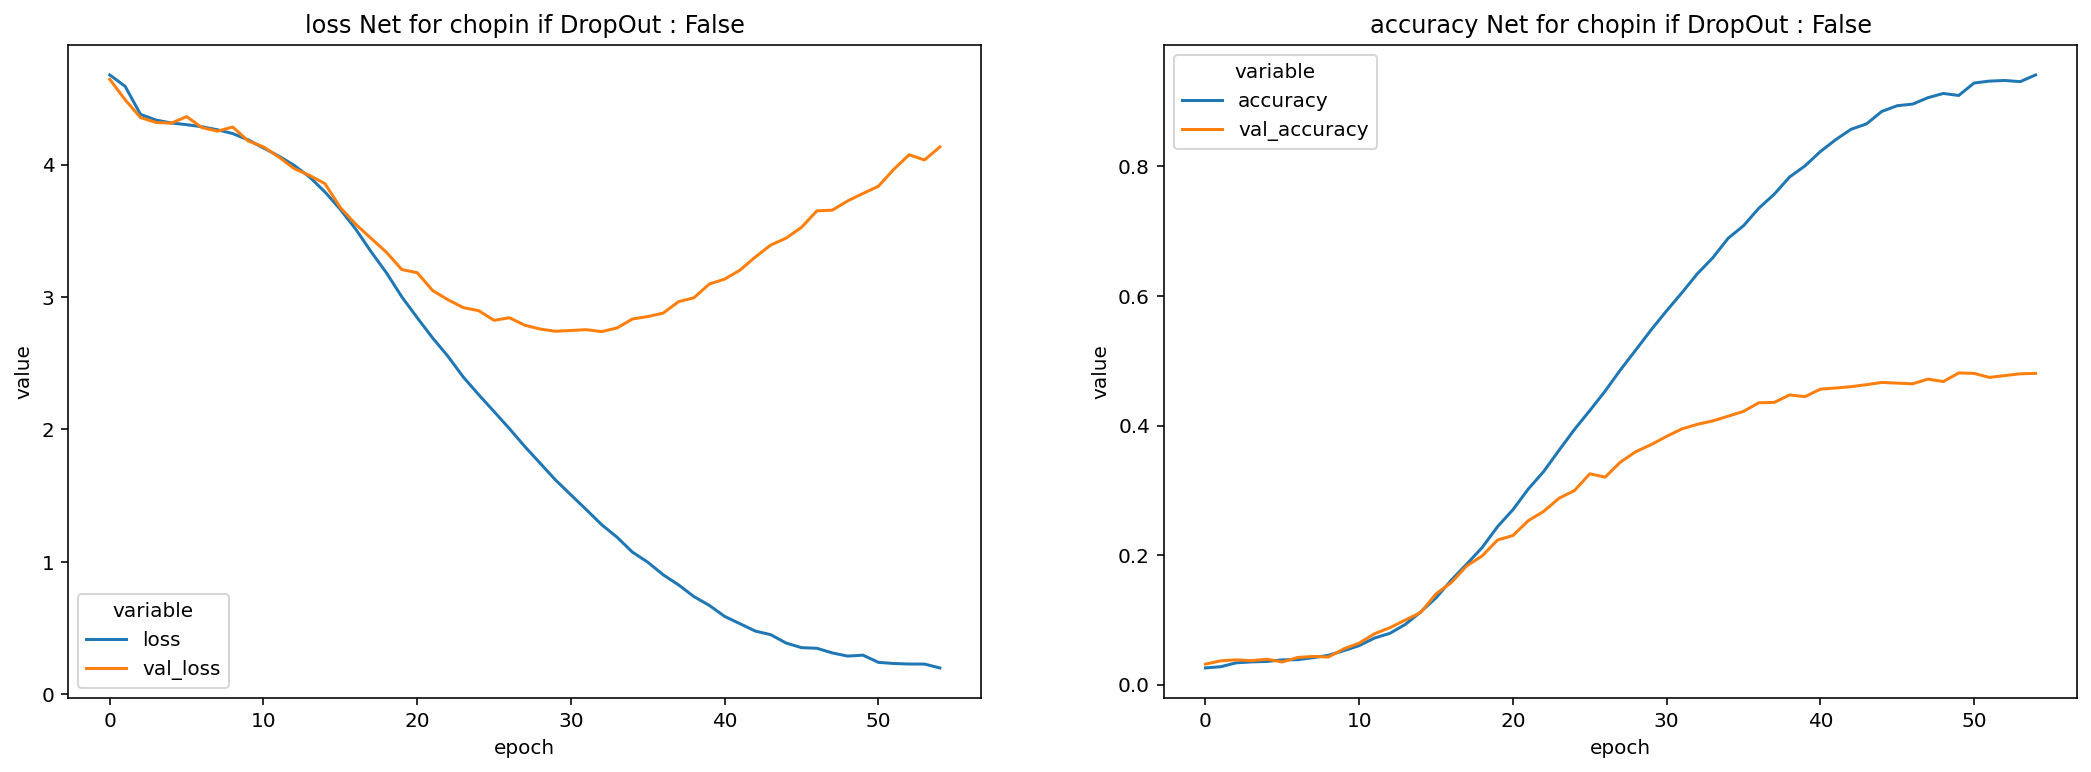

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 251)              

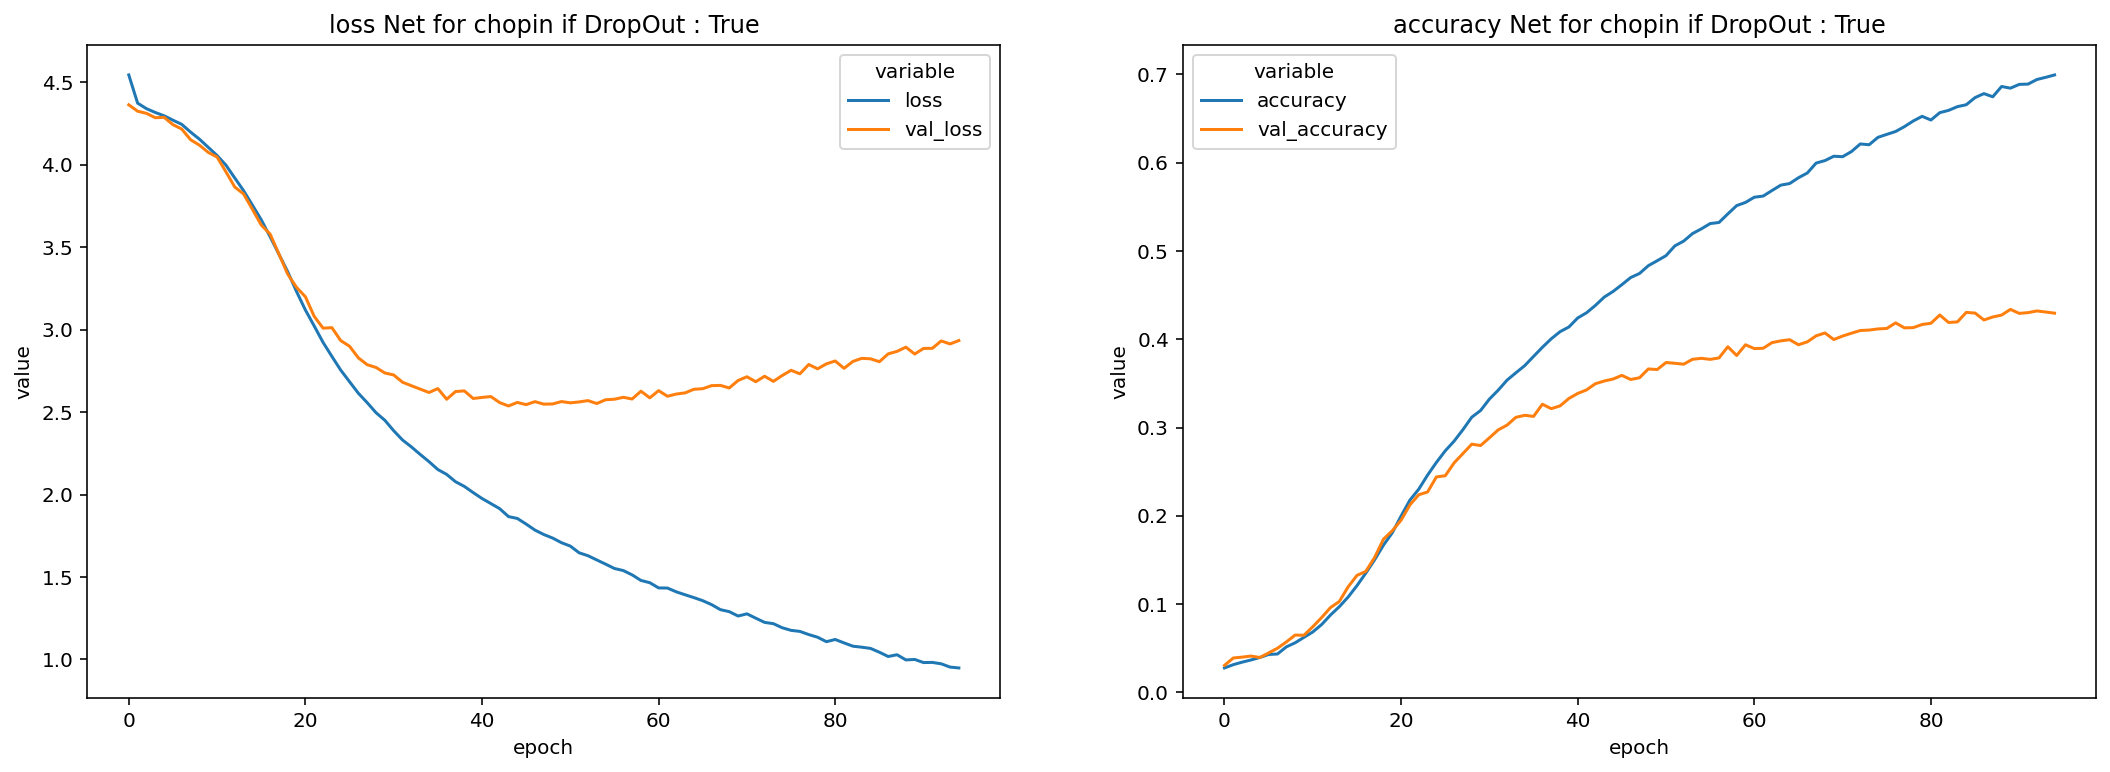

CPU times: user 35min 51s, sys: 1min 11s, total: 37min 3s
Wall time: 50min 34s


In [6]:
%%time
path = '/content/drive/MyDrive/ANN/MP2/chopin/*.mid'

evaluate_model(artist='chopin', address=path)

/content/drive/MyDrive/ANN/MP2/mozart/mz_570_3.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_330_1.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_570_1.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_311_2.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_332_1.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_330_2.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_332_2.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_545_1.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_311_1.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_333_1.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_332_3.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_333_2.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_331_1.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_333_3.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_331_2.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_545_3.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_311_3.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_330_3.mid
/content/drive/MyDrive/ANN/MP2/mozart/mz_331_3.mid
/content/drive/MyDrive/ANN/MP2/

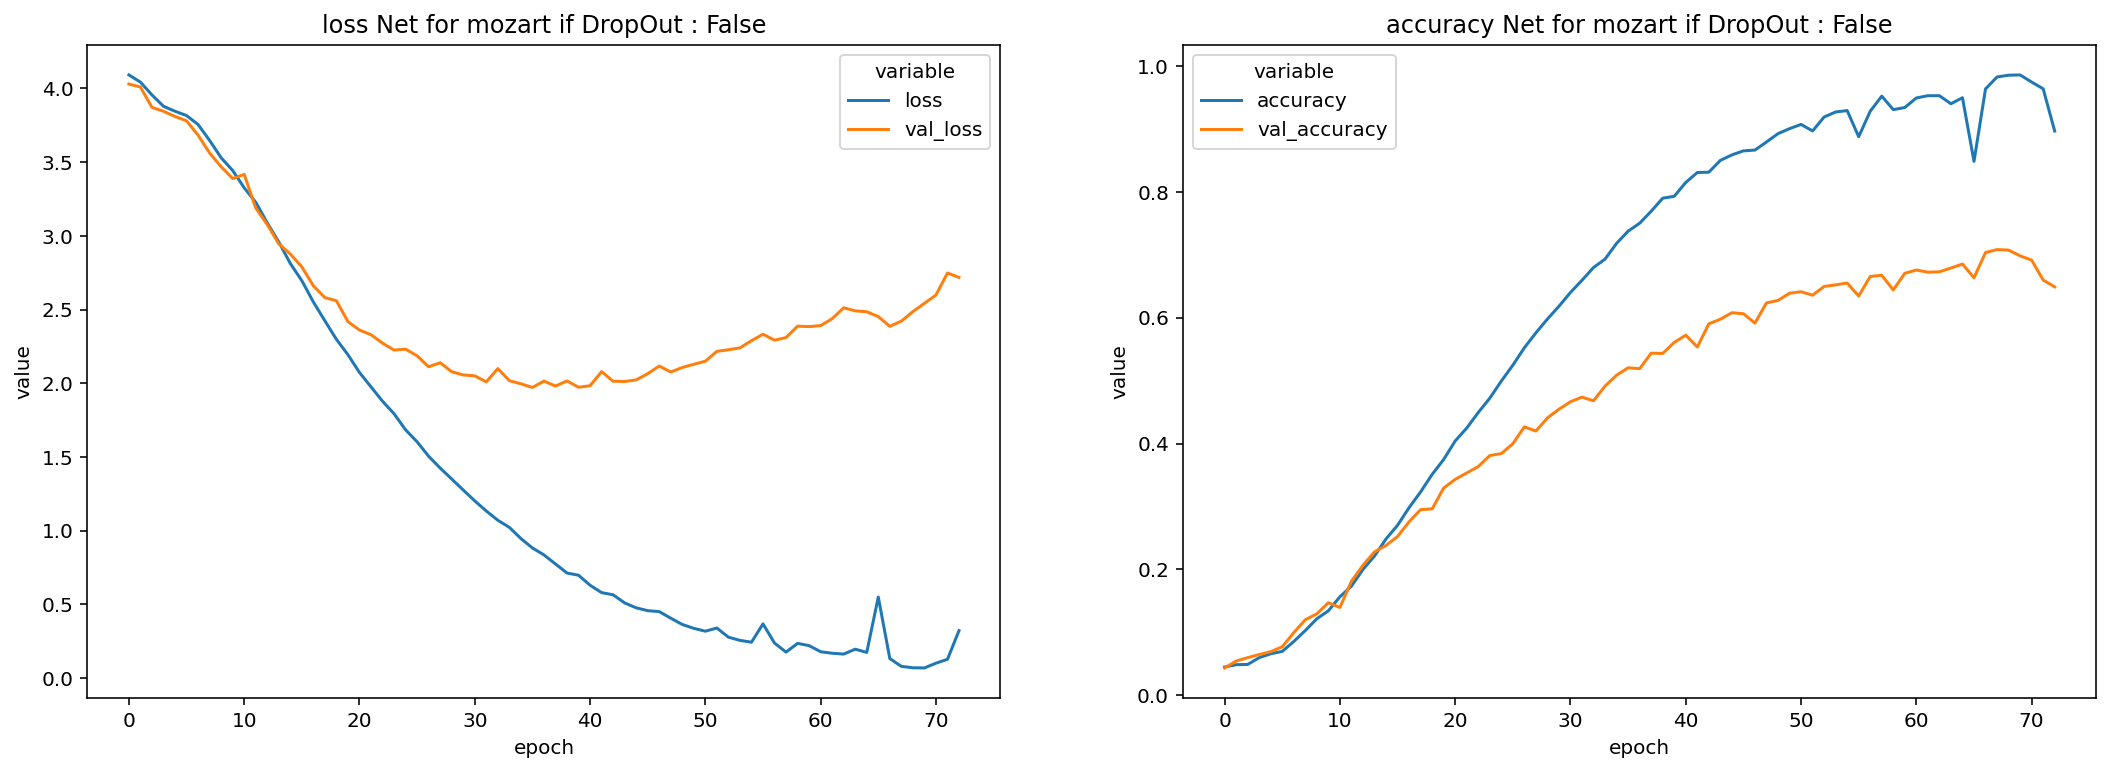

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout_3 (Dropout)         (None, 40, 512)           0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 169)              

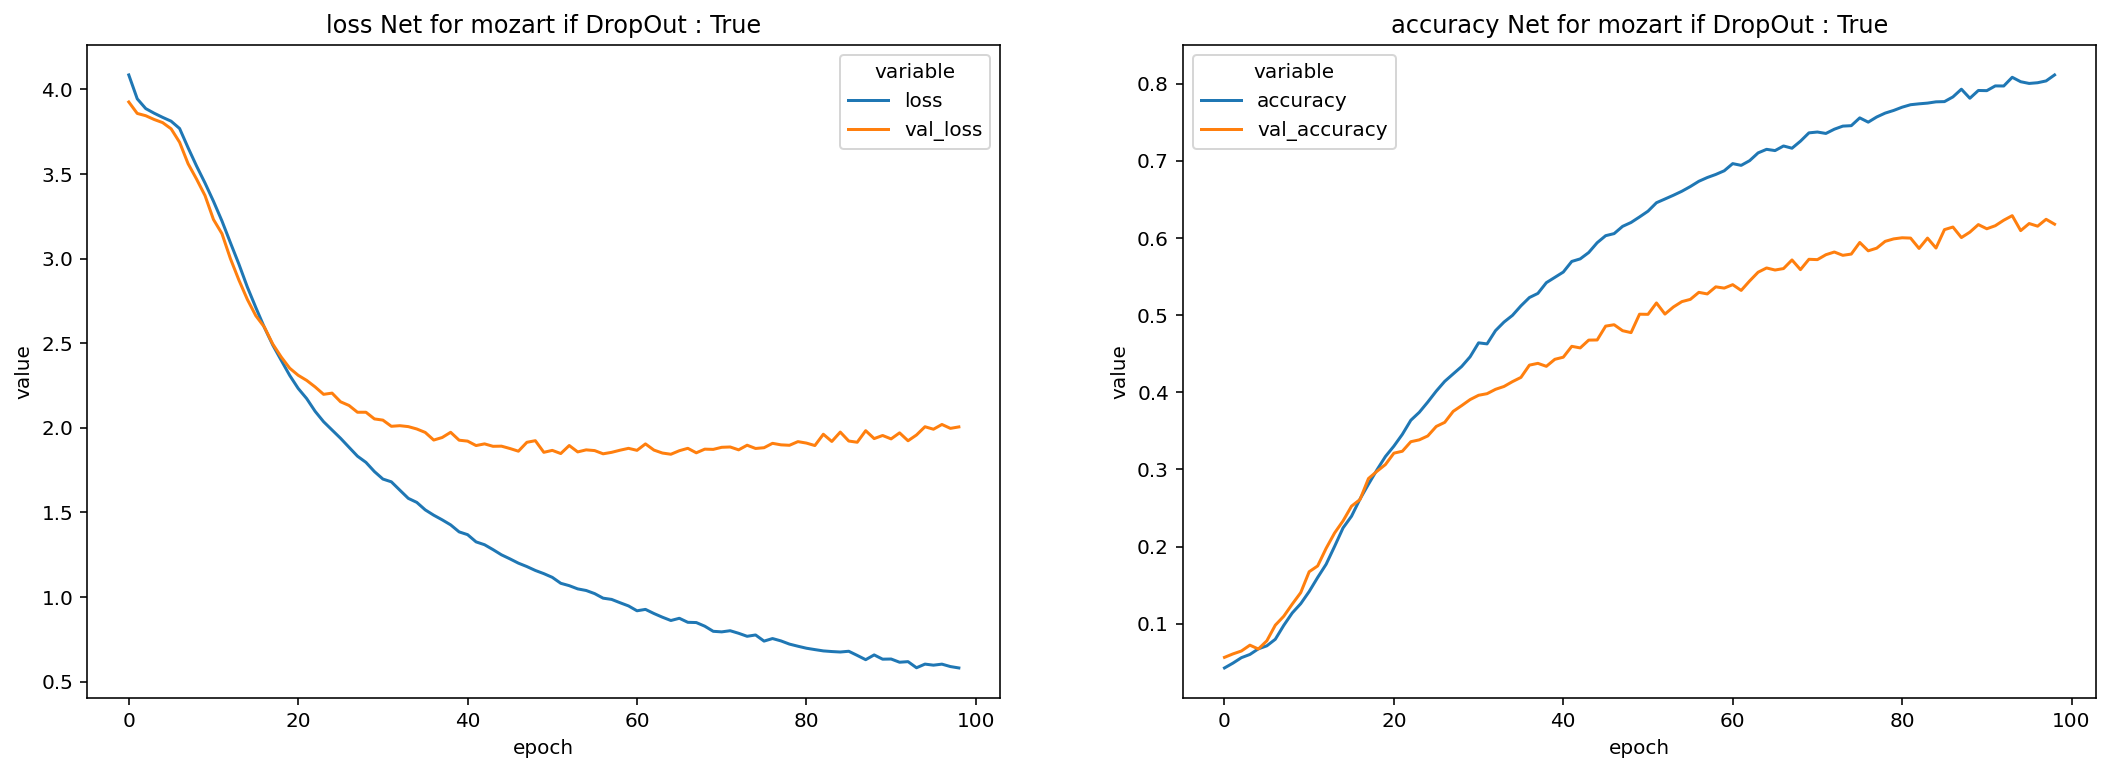

CPU times: user 40min 59s, sys: 1min 20s, total: 42min 19s
Wall time: 57min 13s


In [8]:
%%time
path = '/content/drive/MyDrive/ANN/MP2/mozart/*.mid'

evaluate_model(artist='mozart', address=path) 

In [7]:
!git clone https://github.com/bearpelican/musicautobot.git 
!apt install musescore fluidsynth
%cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/musicautobot/font.sf2
%pip install midi2audio fluidsynth

!apt-get install lilypond
environment.UserSettings()['lilypondPath']='/usr/bin/lilypond'

Cloning into 'musicautobot'...
remote: Enumerating objects: 4131, done.
remote: Total 4131 (delta 0), reused 0 (delta 0), pack-reused 4131
Receiving objects: 100% (4131/4131), 83.43 MiB | 23.84 MiB/s, done.
Resolving deltas: 100% (2992/2992), done.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon bind9-host desktop-file-utils fluid-soundfont-gm
  fluidr3mono-gm-soundfont geoclue-2.0 geoip-database
  gstreamer1.0-plugins-base iio-sensor-proxy libavahi-core7 libavahi-glib1
  libbind9-160 libbrotli1 libcap2-bin libcdparanoia0 libdaemon0 libdns1100
  libfluidsynth1 libgeoclue-2-0 libgeoip1 libgl1-mesa-glx
  libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libhyphen0 libisc169
  libisccc160 libisccfg160 liblwres160 libmbim-glib4 libmbim-proxy libmm-glib0
  libnl-genl-3-200 libnss-mdns liborc-0.4-0 libpam-cap libportaudio2
  libpulsedsp libqmi-glib5 libqmi-proxy libqt5help5 libq



Melody : Chopin_Dropout_False



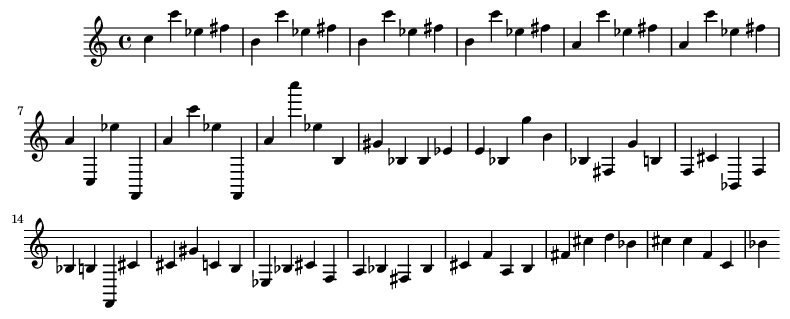



Melody : Mozart_Dropout_False



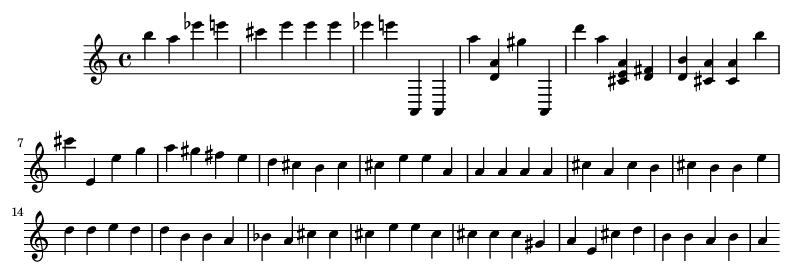



Melody : Chopin_Dropout_True



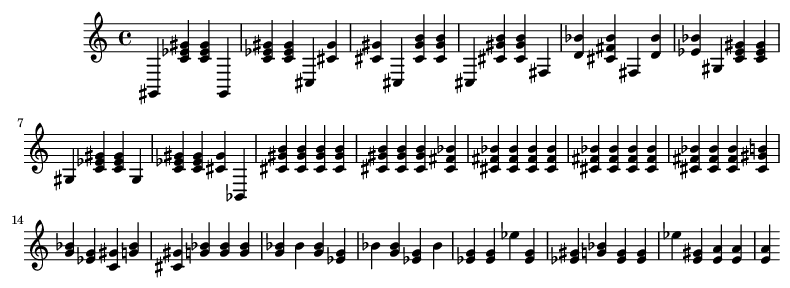



Melody : Mozart_Dropout_True



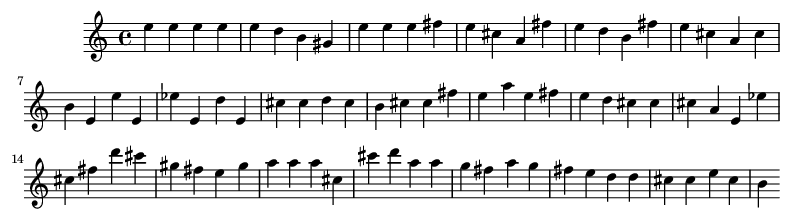

In [12]:
from midi2audio import FluidSynth 
from IPython import display
    

fs = FluidSynth('/content/musicautobot/font.sf2')
for mid_file in glob.glob('/content/*.mid'):
    file_name = mid_file.split('.',1)[0].rsplit('/',1)[1]
    print(f"\n\nMelody : {file_name.split('_',2)[-1].title()}\n")

    address_img = str(converter.parse(mid_file).chordify().write('lily.png'))
    display.display(display.Image(address_img))

    fs.midi_to_audio(mid_file, f'{file_name}.wav')